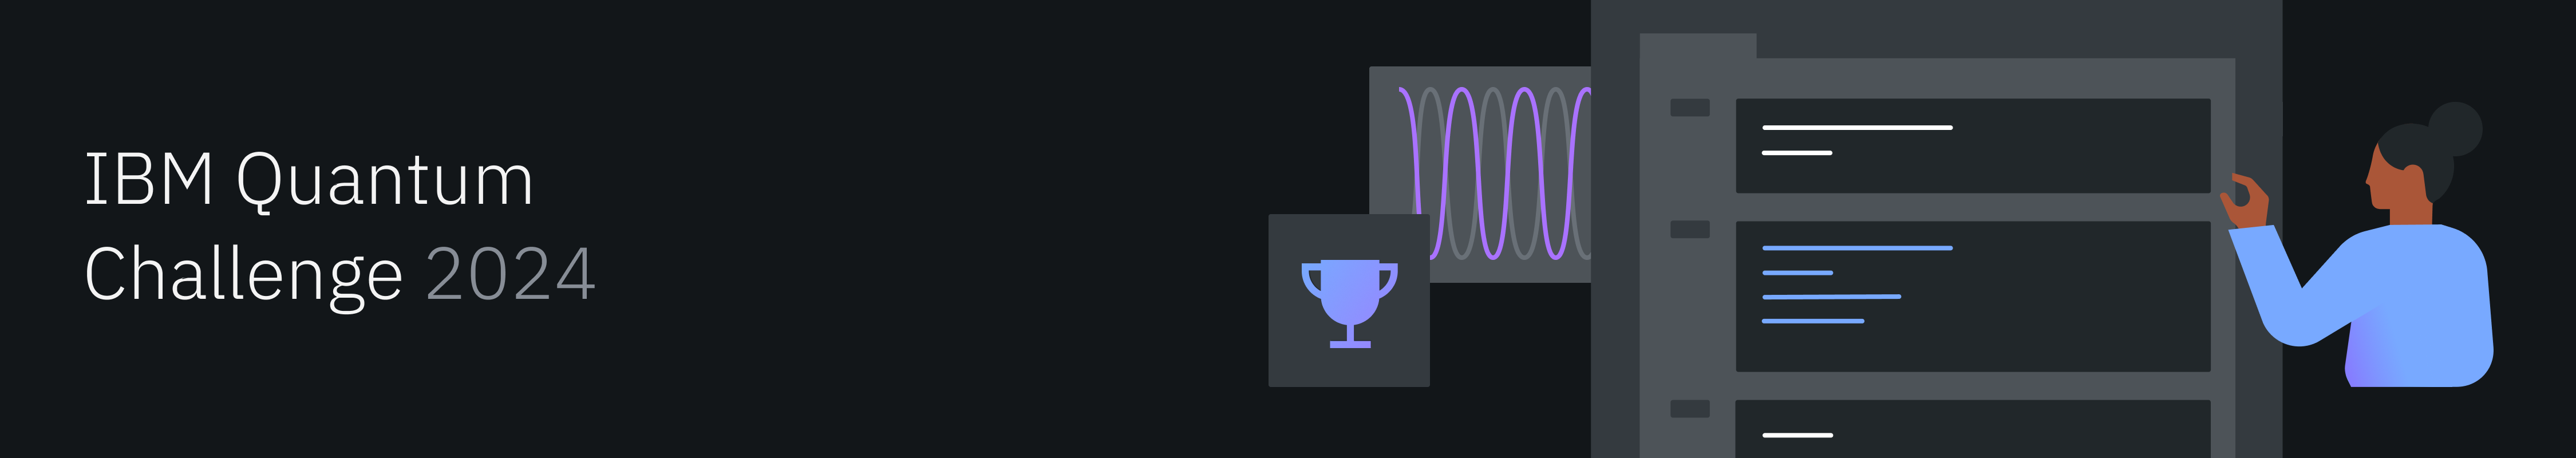

# Transpiler Lab

## Table of contents

- 1. Prologue - What is transpiler
- 2. Transpile with Preset Pass Managers
    - Optimization levels
    - Transpiler Stage Details with Options
    - (extras) Plugins and ecosystem projects
- 3. Build your own Pass Managers with Staged Pass Manager
- 4. Epilogue

# 0.  environment check and setup

Dev env:

- Python version is:  3.10.14 (main, Mar 21 2024, 11:24:58) [Clang 14.0.6 ]
- Qiskit version is:  1.0.2
- Runtime version is:  0.23.0
- Qiskit Aer version is:  0.14.1

In [1]:
import qiskit, qiskit_ibm_runtime, qiskit_aer, sys

print("Python version is: ", sys.version)
print("Qiskit version is: ", qiskit.version.VERSION)
print("Runtime version is: ", qiskit_ibm_runtime.version.VERSION)
print("Qiskit Aer version is: ", qiskit_aer.version.VERSION)

Python version is:  3.10.14 (main, May  6 2024, 14:47:20) [Clang 14.0.6 ]
Qiskit version is:  1.0.2
Runtime version is:  0.23.0
Qiskit Aer version is:  0.14.1


In [2]:
# For Testing purposes. Will remove for the final version

# This is required during testing phase. If you see the following error message:
# Failed: {'errors': [{'message': 'The challenge is not active', 'extensions': {'code': 'INVALID_QUERY'}}]}
# Restart the kernel and run this cell
%set_env QC_GRADE_ONLY=true

# If you see the following error message:
# Failed: Unable to access service (Forbidden)
# Uncomment the line below and copy and past your IBM Quantum token. See lab 0 for more detailed instructions
# %set_env QXToken=#your_token_here

env: QC_GRADE_ONLY=true


# 1. Prologue - What is transpiler

Transpilation is the process of rewriting a given input circuit to an equivalent circuit for a specific quantum device, and/or to optimize the circuit for execution on a real quantum systems, in terms of basis gate set, topology of the quantum chips and timing constraints, etc. The goal of a transpiler is to get the best performance from a noisy quantum hardware so most circuits must undergo a series of transformations that make them compatible with a given target device, and optimize them to reduce the effects of noise on the resulting outcomes. 

The process of transpilation will take a circuit which contains your instructions:

<img src="https://docs.quantum.ibm.com/_next/image?url=%2Fimages%2Ftranspile%2Fpre-transpiled.png&w=640&q=75"/>

And transform it such that only instructions available on a chosen backend are used, and optimizes those instructions in order to minimize the effects of noise:

<img src="https://docs.quantum.ibm.com/_next/image?url=%2Fimages%2Ftranspile%2Ftranspiled.png&w=1920&q=75"/>

A central component of the Qiskit SDK, the transpiler is designed for modularity and extensibility. Its main goal is to write new circuit transformations (known as transpiler passes), and combine them with other existing passes, greatly reducing the depth and complexity of quantum circuits. Which passes are chained together and in which order has a major effect on the final outcome. This pipeline is determined by the [PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager) and [StagedPassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.StagedPassManager) objects. The `StagedPassManager` orchestrates the execution of one or more `PassManagers` and determines the order in which they are executed, while the `PassManager` object is merely a collection of one or more passes. Think of the `StagedPassManager` as the conductor in an orchestra, the `PassManagers` as the different instrument sections, and the `Pass` objects as the individual musicians. In this way, you can compose hardware-efficient quantum circuits that let you execute utility-scale work while keeping noise manageable.


Rewriting quantum circuits to match hardware constraints and optimizing for performance can be far from trivial and Qiskit provide users the standard compilation flow follows the structure given below:

<img src="https://docs.quantum.ibm.com/_next/image?url=%2Fimages%2Fapi%2Fqiskit%2Ftranspiling_core_steps.png&w=3840&q=75"/>


Qiskit has four pre-built transpilation pipelines. By default the preset pass managers are composed of six stages with several options of each stages:

- `Init`: This pass runs any initial passes that are required before we start embedding the circuit to the system. This typically involves unrolling custom instructions and converting the circuit to all single- and two-qubit gates. (By default this will just validate the circuit instructions and translate multi-qubit gates into single- and two-qubit gates.)
  
- `Layout`: This stage applies a layout, mapping the virtual qubits in the circuit to the physical qubits on a backend.

- `Routing`: This stage runs after a layout has been applied and will inject gates (i.e. swaps) into the original circuit to make it compatible with the backend’s connectivity.
  
- `Translation`: This stage translates the gates in the circuit to the target backend’s basis set.
- `Optimization`: This stage runs the main optimization loop repeatedly until a condition (such as fixed depth) is reached.
- `Scheduling`: This stage is for any hardware-aware scheduling passes.

If you are not familiar with quantum circuit optimization by transpiling, the best would be use one of these ready-made routines. Qiskit also prepared 4 pre-defined level of transpilation that users can choose according to their aim. Also, you can modifying these preset pass managers. And in addition to this, it is also possible to construct a pass manager to build an entirely custom pipeline for transforming input circuits. 

After checking your understanding on each transpiling stage, let's take how to use Qiskit's 6 transpile stages with `preset_pass_managers`

<div class="alert alert-block alert-info">
Exercise 1: 

Please match correct answers of each transpilation stages by complete below cells. 

- A. This stage centered around reduce the number of circuit operations and the depth of circuits with serveral optimization options.
- B. This stage inserts the appropriate amount of SWAP gates in order to execute the circuits using the selected layout.
- C. this stage is used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits.
- D. This stage execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device.
- E. this pass can be thought of as explicitly inserting hardware-aware operation like delay instructions to account for the idle time between gate executions, etc.
- F. This stage translates (or unrolls) the gates specified in a circuit to the native basis gates of a specified backend

<b>note</b> The answer will be a single capital letter with quotation mark like "A"

</div>

In [ ]:

ans = {}
ans["init"] = 
ans["layout"] = 
ans["routing"] = 
ans["translation"] = 
ans["optimization"] = 
ans["scheduling"] = 

In [ ]:

from qc_grader.challenges.iqc_2024 import grade_lab2_ex1

grade_lab2_ex1(ans)

# 2. Transpile with Preset Pass Managers

In this part, we will explore how to use Qiskit's standard six transpiler passes. Especially, for your convenience, we will first look at the four pre-defined transpile pipelines, and see how to build your own PassManager through a practice that uses the features and options of each pass with a pre-defined pipeline.

First, let's look at what Passmanager and 'generate_preset_pass_manager' are. This part and later parts refers frequently to [IBM Quantum's Document](https://docs.quantum.ibm.com/transpile) and [API Document](https://docs.quantum.ibm.com/api/qiskit/transpiler) on transpiler, so we recommend you look at them together.


### What is a (staged) pass manager?

A pass manager is an object that stores a list of transpiler passes and can execute them on a circuit. Create a pass manager by initializing a [PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager) with a list of transpiler passes. To run the transpilation on a circuit, call the [run](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager#run) method with a circuit as input.

A staged pass manager is a special kind of pass manager that represents a level of abstraction above that of a normal pass manager. While a normal pass manager is composed of several transpiler passes, a staged pass manager is composed of several pass managers. This is a useful abstraction because transpilation typically happens in discrete stages, as described in Transpiler stages, with each stage being represented by a pass manager. Staged pass managers are represented by the [StagedPassManager](https://docs.quantum.ibm.com/transpile/transpiler-stages) class. 



### `Preset Passmanagers` and `generate_preset_pass_manager`

Preset Passmanagers(`qiskit.transpiler.preset_passmanagers`) contains functions for generating the preset pass managers for the transpiling. The preset pass managers are instances of StagedPassManager which are used to execute the circuit transformations at the different optimization levels, the pre-defined transpiling pipeline. Here we introduce the functions used generate the entire pass manager by using `generate_preset_pass_manager`

`generate_preset_pass_manager` is used to quickly generate a preset pass manager. This function provides a convenient and simple method to construct a standalone `PassManager` object with optimization levels and options of each passes.

Let's first take a look at what is the optimization level and how it works.

## Optimization levels

The `generate_preset_pass_manager` function has one required positional argument, optimization_level, that controls how much effort the transpiler spends on optimizing circuits. This argument can be an integer taking one of the values 0, 1, 2, or 3. Higher optimization levels generate more optimized circuits at the expense of longer compile times. 


<div class="alert alert-block alert-info">
Exercise 2: Build a function to `evaluate` transpiled circuit
</div>

Since the goal of transpiling is to improve the actual execution performance of the circuit, we will create and use a function that measures the performance of the translated circuit very simply for future exercise. We will use `FakeBackendV2` of `qiskit-ibm-runtime` package for this whole lab, and let's make a function which receives transpiled circuit, its **final layout** and it's target backend as its inputs and return score of circuit which **closer to 0 is the better**. 

we already made a helper function and to use it, you need to get the final layout of transpiled circuit. After take a look at these two documents - [layout part of QuantumCircuit API Document](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#layout) and [TranspileLayout part of Qiskit Transpiler API Documents](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.TranspileLayout), complete the code to complete functions.


In [ ]:
def scoring( qc, backend):
    from util import transpile_scoring
    
    layout = #fill this part
    fidelity = transpile_scoring(qc, layout, backend)
    score = #fill this part
    
    return score

In [ ]:
grade_lab2_ex2(scoring)

Now that you have a function to measure the performance of a transposed circuit, let's get into the our transpiler practice.

First, let's import esssential libraries. 

<div class="alert alert-block alert-warning">
<b>Be careful!</b>
    
To pass the grader, don't update random seeds - `seed` and `seed_transpiler` - values through the whole lab.
</div>

In [ ]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.visualization.timeline import draw, IQXDebugging, IQXSimple, IQXStandard
from qiskit.transpiler import StagedPassManager
from qiskit.visualization import plot_circuit_layout
import matplotlib.pyplot as plt


seed = 10000

In [ ]:
## create random circuit. Do not change the seed value

num_qubits = 6
depth = 4
qc = random_circuit(num_qubits,depth,measure=False, seed=seed)

qc.draw('mpl')

Now, to test the performance of each optimization levels, let's bring `FakeTorino` which has conectivity and noise feature of IBM's latest quantum backend, ibm_torino, which has Heron and save it as a `backend`

In [ ]:
backend = FakeTorino()

<div class="alert alert-block alert-success">
Please refer <a href="https://docs.quantum.ibm.com/transpile/set-optimization">this official document</a> for more understandings on optimization_level
</div>


### Optimization level = 0

Optimization level 0 is intended for **device characterization experiments** and, as such, only maps the input circuit to the constraints of the target backend, without performing any optimizations. It performs Layout/Routing with [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout), where it selects the same physical qubit numbers as virtual and inserts SWAPs to make it work (using [StochasticSwap](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.StochasticSwap#stochasticswap)).

Let's make a passmanager with optimization level = 0 with FakeTorino backend and see the result.

In [ ]:

pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)

tr_lv0 = pm_lv0.run(qc)
tr_lv0.draw('mpl', idle_wires=False, fold=60)

As explained, optimization_level=0 is performing a basic gate decomposition by using basis gates of backend and mapping logical qubit to physical qubits just with a same order of number. To compare with other levels, lets compute the score of this circuit and save its circuit depth and the sum of total gate numbers.

In [1]:
circuit_depths = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}
gate_counts = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

scores = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

In [ ]:


# your code here#
depth = 
gate_count = 
score = 

circuit_depths.append(depth)
gate_counts.append(gate_count)
scores.append(score)

print("Circuit depth of tanspiled circuit with optimization_level = 0 is ", depth)
print("Total numbe of gates of tanspiled circuit with optimization_level = 0 is ", gate_count)
print("Score of tanspiled circuit with optimization_level = 0 is ", score)

### Optimization level = 1

Optimization level 1 performs a **`Light optimization`**. 

- Layout/Routing: Layout is first attempted with [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout). If additional SWAPs are required, a layout with a minimum number of SWAPs is found by using [SabreSWAP](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreSwap#sabreswap), then it uses [VF2LayoutPostLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.VF2PostLayout)` to try to select the best qubits in the graph.
- [InverseCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.InverseCancellation#inversecancellation)
- [1Q gate optimization](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGates#optimize1qgates)

Let's make a passmanager by using **generate_preset_pass_manager** with optimization level = 1 with FakeTorino backend with seed_transpiler=seed by yourself and see the result!!

In [ ]:
# complete code by yourself

pm_lv1 = # your code here#

tr_lv1 = pm_lv1.run(qc)
tr_lv1.draw('mpl', idle_wires=False, fold=60)

Like explained,  you can see logical qubit mapped into different physical qubit sets and smaller number of gates. Let's save and print out some important matrixes.

In [ ]:
#your_code here
depth =
gate_count = 
score = 
#your code here

circuit_depths['opt_lv_1'] = depth
gate_counts['opt_lv_1'] = gate_count
scores['opt_lv_1'] = score

print("Circuit depth of tanspiled circuit with optimization_level = 1 is ", depth)
print("Total numbe of gates of tanspiled circuit with optimization_level = 1 is ", gate_count)
print("Score of tanspiled circuit with optimization_level = 1 is ", score)

#### Optimization level = 2

Optimization level 2 performs a **`Medium optimization`**:

- Layout/Routing: Optimization level 1 (without trivial) + heuristic optimized with greater search depth and trials of optimization function. Because [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout) is not used, there is no attempt to use the same physical and virtual qubit numbers.
- [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation#commutativecancellation)

Let's make a passmanager with optimization level = 2 with FakeTorino backend with seed_transpiler=seed and see the result.

In [ ]:
pm_lv2 = # your code here

tr_lv2 = pm_sim_lv2.run(qc)
tr_lv2.draw('mpl', fold=60)

Even at a glance, we can see that the number of gates has decreased a lot. The physical qubit to which the logical qubit mapping remains unchanged. Now, let's measure the performance of transpiling. It is the same code above.

In [ ]:
depth = 
gate_count = 
score = 

circuit_depths['opt_lv_2'] = depth
gate_counts['opt_lv_2'] = gate_count
scores['opt_lv_2'] = score

print("Circuit depth of tanspiled circuit with optimization_level = 2 is ", depth)
print("Total numbe of gates of tanspiled circuit with optimization_level = 2 is ", gate_count)
print("Score of tanspiled circuit with optimization_level = 2 is ", score)

#### Optimization level = 3

Optimization level 3 performs a **`High Optimization`**:

- Optimization level 2 + heuristic optimized on layout/routing further with greater effort/trials
- Resynthesis of two-qubit blocks using [Cartan's KAK Decomposition](https://arxiv.org/abs/quant-ph/0507171).
- Unitarity-breaking passes:
    - `OptimizeSwapBeforeMeasure`: Remove swaps in front of measurements by re-targeting
    the classical bit of the measure instruction to avoid SWAPs
    - `RemoveDiagonalGatesBeforeMeasure`: Remove diagonal gates (like RZ, T, Z, etc) before
    a measurement. Including diagonal 2Q gates.

Now you will know what you need to do.

In [ ]:
pm_lv3 = 

tr_lv3 = 
tr_lv3.draw('mpl', idle_wires=False, fold=60)

Surprising! Now we have a less number of gates! Can't wait to see how it worked.

In [ ]:
depth = 
gate_count = 
score = 

circuit_depths['opt_lv_3'] = depth
gate_counts['opt_lv_3'] = gate_count
scores['opt_lv_3'] = score

print("Circuit depth of tanspiled circuit with optimization_level = 3 is ", depth)
print("Total numbe of gates of tanspiled circuit with optimization_level = 3 is ", gate_count)
print("Score of tanspiled circuit with optimization_level = 3 is ", score)

Let's graph how much the depth of the circuit, the number of gates, and the evaluation score have changed according to each optimization level.

In [ ]:
ax = list(circuit_depths.keys())


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.semilogy(ax, [circuit_depths[key] for key in ax],'o-',markersize=5, label="Depth")
ax1.set_xlabel("optimization level")
ax1.set_ylabel("Depth")
ax1.legend()
ax1.set_title("Circuit depth of the transpiled circuit")
ax2.semilogy(ax, [gate_counts[key] for key in ax],'^-',markersize=5, label="Counts")
ax2.set_xlabel("optimization level")
ax2.set_ylabel("# of total gates")
ax2.legend()
ax2.set_title("Total number of gates in the transpiled circuit")
ax3.semilogy(ax, [scores[key] for key in ax],'*-',markersize=5, label="Score")
ax3.set_xlabel("optimization level")
ax3.set_ylabel("Score")
ax3.legend()
ax3.set_title("Score of the transpiled circuit")
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
Exercise 3:

Submit 4 passmanagers and see if you did correct. Please make sure you didn't updated random seed values.
</div>


In [ ]:
from lab2_grader import grade_lab2_ex3

ans = [pm_lv0, pm_lv1, pm_lv2, pm_lv3]

grade_lab2_ex3(ans)

## Transpiler Stage Details with Options

So far, we've looked at four predefined transpiller pipelines offered by Qiskit using random circuits. One of the key features of Qiskit 1.0 transpiller is to make it easy for users to  custom Passmanager. The easiest way is to configure your own Passmanager by using six standard passes along with the optimization level discussed above, but choosing the option or plug-in for each pass as you like, and another way is to create Passmanager with as many passes as you want by using `StagedPassManager`. In addition, you can create and deploy a new PassManager and implement it in the form of Plugin in Qiskit so that other users can use it.

Let's look at all three of them in the following sections. Let's look at the easiest way first.

### 1. Init stage

This first stage does very little by default and is primarily useful if you want to include your own initial optimizations. Because most layout and routing algorithms are only designed to work with single- and two-qubit gates, this stage is also used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits.

If you specify an argument at this stage for the qubits you want to use, that value overrides all the passes that could change it. You can find more details at [this document](https://docs.quantum.ibm.com/transpile/defaults-and-configuration-options)

First, let's check possible options of init stage we can use.

In [ ]:
list_stage_plugins("init")

Without extra plugins, only default option exist. This stage runs first and is typically used for any initial logical optimization. Because most layout and routing algorithms are only designed to work with 1 and 2 qubit gates, this stage is also used to translate any gates that operate on more than 2 qubits into gates that only operate on 1 or 2 qubits. This process includes several transpier pass plugins depends on the `optimization_level` and let's take a look at inside of it.

For this, let's create a passmanage'r with `init_method="default"` options.

In [ ]:
for i in range(4):
    print("Plugins run for default init stage with optimization level", i , "is: ")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, init_method="default", seed_transpiler=1000) 
    for task in pm.init.to_flow_controller().tasks:
        print(" -", type(task).__name__)

Here is the table of each plugin api documents, and hopefully, take a look at if you want to dive into.

| plugin | Description | api document link|
|---- | ---- | ------|
|UnitarySynthesis| Synthesize unitaries over some basis gates. | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.UnitarySynthesis#unitarysynthesis |
|HighLevelSynthesis |Synthesize higher-level objects and unroll custom definitions| https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.HighLevelSynthesis#highlevelsynthesis |
| BasisTranslator | Translates gates to a target basis by searching for a set of translations from a given EquivalenceLibrary. | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.BasisTranslator#basistranslator |
| InverseCancellation| Cancel specific Gates which are inverses of each other when they occur back-to- back | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.InverseCancellation#inversecancellation |
| OptimizeSwapBeforeMeasure | Moves the measurements around to avoid SWAPs | NA |
| RemoveDiagonalGatesBeforeMeasure | Remove diagonal gates (including diagonal 2Q gates) before a measurement. | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.RemoveDiagonalGatesBeforeMeasure |


### 2 Layout Stage

The next stage involves the layout or connectivity of the backend a circuit will be sent to. In general, quantum circuits are abstract entities whose qubits are "virtual" or "logical" representations of actual qubits used in computations. To execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device is necesary. This mapping is stored as a Layout object and is part of the constraints defined within a backend's instruction set architecture (ISA).

<img src="https://docs.quantum.ibm.com/_next/image?url=%2Fimages%2Ftranspile%2Ftranspiler-stages%2Flayout-mapping.png&w=3840&q=75" width="1000"/>

The choice of mapping is extremely important for minimizing the number of SWAP operations needed to map the input circuit onto the device topology and ensure the most well-calibrated qubits are used. Due to the importance of this stage, the preset pass managers try a few different methods to find the best layout. Typically this involves two steps: first, try to find a "perfect" layout (a layout that does not require any SWAP operations), and then, a heuristic pass that tries to find the best layout to use if a perfect layout cannot be found. There are two Passes typically used for this first step:

- [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout): Naively maps each virtual qubit to the same numbered physical qubit on the device (i.e., [0,1,1,3] -> [0,1,1,3]). This is historical behavior only used in optimzation_level=1 to try to find a perfect layout. If it fails, VF2Layout is tried next.
- [VF2Layout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.VF2Layout): This is an AnalysisPass that selects an ideal layout by treating this stage as a subgraph isomorphism problem, solved by the VF2++ algorithm. If more than one layout is found, a scoring heuristic is run to select the mapping with the lowest average error.
  
Then for the heuristic stage, two passes are used by default:

- [DenseLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.DenseLayout): Finds the sub-graph of the device with the greatest connectivity and that has the same number of qubits as the circuit (used for optimization level 1 if there are control flow operations (such as IfElseOp) present in the circuit).
- [SabreLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreLayout): This pass selects a layout by starting from an initial random layout and repeatedly running the SabreSwap algorithm. This pass is only used in optimization levels 1, 2, and 3 if a perfect layout isn't found via the VF2Layout pass. For more details on this algorithm, refer to the paper [arXiv:1809.02573](arXiv:1809.02573).

We can find these 4 passes by using same code with init stage

In [ ]:
list_stage_plugins("layout")

First, let's check which tasks will be enabled by which optimization_level with `layout_method='default'` option by running below code

In [ ]:
for i in range(4):
    print("Plugins run for layout stage with optimization level", i , "is: ")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, layout_method='default', seed_transpiler=seed)
    qc_tr = pm.run(qc)

    for controller_group in pm.layout.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:  
            print(" - " , str(type(task).__name__))
    print(qc_tr.layout.final_index_layout())
    display(plot_circuit_layout(pm.run(qc), backend))

Now let's compare the score and layout of each options with optimization_level=3.

In [ ]:
for option in list_stage_plugins("layout"):
    
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, layout_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)

    print("the score of layout_method =", option, "is ", score, "with layout ", qc_tr.layout.final_index_layout())

### 3. Routing Stage

In order to implement a two-qubit gate between qubits that are not directly connected on a quantum device, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map. Each SWAP gate represents an expensive and noisy operation to perform. Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device is an important step in the transpilation process. For efficiency, this stage is typically computed alongside the Layout stage by default, but they are logically distinct from one another. The Layout stage selects the hardware qubits to be used, while the Routing stage inserts the appropriate amount of SWAP gates in order to execute the circuits using the selected layout.

However, finding the optimal SWAP mapping is hard. In fact, it is an NP-hard problem, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits. To work around this, Qiskit uses a stochastic heuristic algorithm called SabreSwap to compute a good, but not necessarily optimal, SWAP mapping. The use of a stochastic method means that the circuits generated are not guaranteed to be the same over repeated runs. Indeed, running the same circuit repeatedly results in a distribution of circuit depths and gate counts at the output. It is for this reason that many users choose to run the routing function (or the entire StagedPassManager) many times and select the lowest-depth circuits from the distribution of outputs.

In [ ]:
list_stage_plugins("routing")

In [ ]:
for i in range(4):
    print("Number of each gates of traspiled circuit with optimization level", i , "is: ")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print("The score of this transpiled circuit is:", score)

In [ ]:
for i in range(4):
    print("Plugins run for layout stage with optimization level", i , "is: ")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed) 

    for controller_group in pm.routing.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:
            print(" - " , str(type(task).__name__))
    display(pm.routing.draw())
    print(pm.run(qc).layout.final_index_layout())

In [ ]:
## process stopped due to lookahead
options = ['basic','sabre', 'stochastic']

for option in options:
    print("Number of each gates of traspiled circuit with optimization level=3 and option ", option , "is: ")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, routing_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print("The score of this transpiled circuit is:", score)

### 4 Translation Stage

When writing a quantum circuit, you are free to use any quantum gate (unitary operation) that you like, along with a collection of non-gate operations such as qubit measurement or reset instructions. However, most quantum devices only natively support a handful of quantum gate and non-gate operations. These native gates are part of the definition of a target's ISA and this stage of the preset PassManagers translates (or unrolls) the gates specified in a circuit to the native basis gates of a specified backend. This is an important step, as it allows the circuit to be executed by the backend, but typically leads to an increase in the depth and number of gates.

Two special cases are especially important to highlight, and help illustrate what this stage does.

1. If a SWAP gate is not a native gate to the target backend, this requires three CNOT gates: As a product of three CNOT gates, a SWAP is an expensive operation to perform on noisy quantum devices. However, such operations are usually necessary for embedding a circuit into the limited gate connectivities of many devices. Thus, minimizing the number of SWAP gates in a circuit is a primary goal in the transpilation process.

2. A Toffoli, or controlled-controlled-not gate (ccx), is a three-qubit gate. Given that our basis gate set includes only single- and two-qubit gates, this operation must be decomposed. However, it is quite costly: For every Toffoli gate in a quantum circuit, the hardware may execute up to six CNOT gates and a handful of single-qubit gates. This example demonstrates that any algorithm making use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affected by noise.

let's check how many options we can use:

In [ ]:
list_stage_plugins("translation")

The basic options by Qiskit is 'translator' and 'synthesis'. Let's count total gate numbers, circuit depth and scores of transpiled circuit with default option ('translator') and each optimization levels

In [ ]:
for i in range(4):
    print("Number of each gates of traspiled circuit with optimization level", i , "is: ")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method='translator', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print("The score of this transpiled circuit is:", score)

Let's count total gate numbers, circuit depth and scores of transpiled circuit with each options and optimization_level=3

In [ ]:
options = ['translator', 'synthesis']
for option in options:
    print("Number of each gates of traspiled circuit with optimization level=3 and option ", option , "is: ")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, translation_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print("The score of this transpiled circuit is:", score)

get a graph

In [ ]:
tr_depths = []
tr_gate_counts = []
tr_scores = []

options = ['translator', 'synthesis']

for i in range(4):
    for option in options:
        pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method=option, seed_transpiler=seed) 
    
        tr_depths.append(pm.run(qc).depth())
        tr_gate_counts.append(sum(pm.run(qc).count_ops().values()))
        tr_scores.append(scoring(pm.run(qc), backend))

In [ ]:
colors = ['#FF6666', '#66B2FF']


markers = [ '^', '*']
linestyles = ['-.', ':']

opt_list = []
for i in range(4):
    opt_list.append(f"Optimization Level {i}")

ax = opt_list
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
for i in range(2):
    ax1.plot(ax, tr_depths[i:i+4], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("translation options", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(2):
    ax2.plot(ax, tr_gate_counts[i:i+4], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("translation options", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
for i in range(2):
    ax3.plot(ax, tr_scores[i:i+4], label=options[i], marker=markers[i],markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("translation options", fontsize=12)
ax3.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax3.set_title("Score of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

### 5 Optimization Stage

Decomposing quantum circuits into the basis gate set of the target device, and the addition of swap gates needed to match hardware topology, conspire to increase the depth and gate count of quantum circuits. Fortunately many routines for optimizing circuits by combining or eliminating gates exist. In some cases these methods are so effective the output circuits have lower depth than the inputs. In other cases, not much can be done, and the computation may be difficult to perform on noisy devices. Different gate optimizations are turned on with different optimization_level values.

- For optimization_level=1, this stage prepares [Optimize1qGatesDecomposition](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition) and [CXCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CXCancellation), which combine chains of single-qubit gates and cancel any back-to-back CNOT gates.
- For optimization_level=2, this stage uses the [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation) pass instead of `CXCancellation`, which removes redundant gates by exploiting commutation relations.
- For optimization_level=3, this stage prepares the following passes- [Collect2qBlocks](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Collect2qBlocks), [ConsolidateBlocks](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.ConsolidateBlocks), [UnitarySynthesis](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.UnitarySynthesis), [Optimize1qGateDecomposition](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition), [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation). 
Additionally, this stage also executes a few final checks to make sure that all instructions in the circuit are composed of the basis gates available on the target backend.


At this stage, we can set-up two options:

- approximation_degree (float, in the range 0-1 | None) - Heuristic dial used for circuit approximation (1.0 = no approximation, 0.0 = maximal approximation). The default value is 1.0. Specifying None sets the approximation degree to the reported error rate. See the Approximation degree section for more details.
- optimization_method (str) - The plugin name to use for the optimization stage. By default an external plugin is not used. You can see a list of installed plugins by running list_stage_plugins() with optimization for the stage_name argument.

As this stage is deeply relate to optimizing gates of circuits, let's try to plot the 1) total gate number, 2) circuit depth and score of transpiled circuit with each optimization_level with different approximation_degree values- $[ 0, 0.1, 0.2, ... ,0.9, 1]$.

In [ ]:
import numpy as np

tr_depths = []
tr_gate_counts = []
tr_scores = []

approximation_degree_list = np.linspace(0,1,10)

for i in range(4):
    for j in approximation_degree_list:
        # your code here #


        # your code here #

In [ ]:
colors = ['#FF6666', '#FFCC66', '#99FF99', '#66B2FF']


markers = ['o', 's', '^', '*']
linestyles = ['-', '--', '-.', ':']

ax = approximation_degree_list
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
for i in range(4):
    ax1.plot(ax, tr_depths[i::4], label=f"Optimization Level {i}", marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("Approximation Degree", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(4):
    ax2.plot(ax, tr_gate_counts[i::4], label=f"Optimization Level {i}", marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("Approximation Degree", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
for i in range(4):
    ax3.plot(ax, tr_scores[i::4], label=f"Optimization Level {i}", marker=markers[i],markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("Approximation Degree", fontsize=12)
ax3.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax3.set_title("Score of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

### 6 Scheduling Stage

This last stage is only run if it is explicitly called for (similar to the Init stage) and does not run by default (though a method can be specified by setting the 1scheduling_method1 argument when calling `generate_preset_pass_manager`). The scheduling stage is typically used once the circuit has been translated to the target basis, mapped to the device, and optimized. These passes focus on accounting for all the idle time in a circuit. At a high level, the scheduling pass can be thought of as explicitly inserting delay instructions to account for the idle time between gate executions and to inspect how long the circuit will be running on the backend.

First, let'sc check which option we can use.

In [ ]:
list_stage_plugins("scheduling")

To use scheduling options, let's first prepare `timing_constraints` which contains relevant information of backend to get the optimized pulse schedule.

In [ ]:
backend_timing = backend.target.timing_constraints()
timing_constraints = TimingConstraints(
    granularity=backend_timing.granularity,
    min_length=backend_timing.min_length,
    pulse_alignment=backend_timing.pulse_alignment,
    acquire_alignment=backend_timing.acquire_alignment )

In [ ]:

# Run with optimization level 3 and 'asap' scheduling pass
pm_asap = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    timing_constraints=timing_constraints,
    scheduling_method="asap",
    seed_transpiler=seed,
)

In [ ]:
my_style = {
                'formatter.general.fig_width': 40,
                'formatter.general.fig_unit_height': 1,
            }

draw(pm_asap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

In [ ]:
pm_alap = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    timing_constraints=timing_constraints,
    scheduling_method="alap",
    seed_transpiler=seed,
)
draw(pm_alap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

As you can see, these two circuit have a lot of delays but the position and order is different. Depends on circuit and backend, this scheduling can bring differences in performance. Let's check and compare the score of these two circuits.

In [ ]:
[scoring(pm_asap.run(qc), backend), scoring(pm_alap.run(qc), backend)]

<div class="alert alert-block alert-info">
Exercise 4:

Make a passmanager with below options

1) optimization level = 3
2) "sabre" layout
3) "sabre" routing
4) "synthesis" translation
   
</div>

In [ ]:
pm_ex4 = generate_preset_pass_manager(
    backend=backend,
    #your code here

    #your code here
)

In [ ]:
from lab2_grader import grade_lab2_ex4 

grade_lab2_ex4(pm_ex4)

### (Extra Part) Ecosystem and Qiskit Transpiler Plugin

To facilitate the development and reuse of custom transpilation code by the wider community of Qiskit users, the Qiskit SDK supports a plugin interface that enables third-party Python packages to declare that they provide extended transpilation functionality accessible via Qiskit. Currently, third-party plugins can provide extended transpilation functionality in three ways:

- [A transpiler stage plugin](https://docs.quantum.ibm.com/api/qiskit/transpiler_plugins) provides a pass manager that can be used in place of one of the 6 stages of a preset staged pass manager: init, layout, routing, translation, optimization, and scheduling. 
- [A unitary synthesis plugin](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.synthesis.plugin.UnitarySynthesisPlugin) provides extended functionality for unitary gate synthesis.
- [A high-level synthesis plugin](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.synthesis.plugin.HighLevelSynthesisPlugin) provides extended functionality for synthesizing "high-level objects" such as linear functions or Clifford operators. High-level objects are represented by subclasses of the [Operation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Operation) class.


Refer [this page](https://docs.quantum.ibm.com/transpile/transpiler-plugins) for more informations including how to install new ones, and use them.

Also, you can be a `contributor` of these plugins! Creating a transpiler plugin is a great way to share your transpilation code with the wider Qiskit community, allowing other users to benefit from the functionality you've developed. [Here](https://docs.quantum.ibm.com/transpile/create-a-transpiler-plugin) you can find guidlines and instructions about how to contribute to Qiskit Community by providing nice transpiler plugins.

## 3. Build your own Pass Managers with Staged Pass Manager

One of the powerful feature of qiskit1.0 transpiler is the "flexibility". It allows you compose a `PassManager` only has two stages or 3 stages. Also it allows you put your own `Pass` at desired stages. 

#### Make a function that returns `Dynamic Decoupling` Pass

Here, we will try to build a custom `scheduling` pass to perform a `Dynamic Decoupling`, which works by adding pulse sequences (known as dynamical decoupling sequences) to idle qubits to flip them around the Bloch sphere, which cancels the effect of noise channels, thereby suppressing decoherence. These pulse sequences are similar to refocusing pulses used in nuclear magnetic resonance. For a full description, see [A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560). For your better understanding, here you can learn by `Nick Bronn` what is the dynamic decoupling - https://www.youtube.com/watch?v=67jRWQuW3Fk. To finish this part, you many want to take a look at [this official documentation about creading a dynamic decoupling pass](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager) and [this documentation](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager).

We will use same quantum circuit that we've been used before. A dynamical decoupling sequence is a series of gates that compose to the identity and are spaced regularly in time. For example, start by creating a simple sequence called XY4 consisting of four gates.

In [ ]:
from qiskit.circuit.library import XGate, YGate
 
X = XGate()
Y = YGate()
 
dd_sequence = [X, Y, X, Y]

Because of the regular timing of dynamical decoupling sequences, information about the YGate must be added to the target because it is not a basis gate, whereas the XGate is. We know a priori that the YGate has the same duration and error as the XGate, however, so we can just retrieve those properties from the target and add them back for the YGates. This is also why the basis_gates were saved separately, since we are adding the YGate instruction to the target although it is not an actual basis gate of our backend - ibm_torino.

In [ ]:
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.transpiler import PassManager

backend=FakeTorino()

target = backend.target

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )
 
target.add_instruction(YGate(), y_gate_properties)

Next, execute the custom passes. Instantiate the PassManager with `ALAPScheduleAnalysi`s and `PadDynamicalDecoupling`. Run `ASAPScheduleAnalysis` first to add timing information about the quantum circuit before the regularly-spaced dynamical decoupling sequences can be added. These pass\es are run on the circuit with .run().

In [ ]:
dd_pm = PassManager(
    [
        ## your code here

        ## your code here
        
    ]
)

And let's see how it works by comparing it with a `Timing` of `asap` scheduling option. First, let's bring the timing drawing from above.


In [ ]:
draw(pm_asap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

Now, let's make a custom scheduling `Pass` by using the function we've created.

for using this new `scheduling pass` we will use `StagedPassManager`. We can make a PassManager that only have 1 pass. After making a custom staged PassManager, we will apply this to the transpiled circuit by pm_asap, that we already made above. 

In [ ]:
staged_pm_dd = StagedPassManager(
    stages=["scheduling"], 
    scheduling=dd_pm
)

In [ ]:
qc_tr = pm_asap.run(qc)
draw(staged_pm_dd.run(qc_tr), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

<div class="alert alert-block alert-info">
Exercise 5:

Submit the PassManager you made which only has 1 pass - the scheduling pass.
</div>

In [ ]:
from lab2_grader import grade_lab2_ex5 

grade_lab2_ex5(staged_pm_dd)

# Additional information

<b>Created by:</b> Sophy Shin, Sumit Suresh Kale

<b>Special Thanks to:</b> Va barbosa, Junye Huang

Version: 1.0